# Imports

In [1]:
# general
import torch
import numpy as np
from tqdm.notebook import tqdm
import random
import warnings

# data
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
from transformers import AutoModelForCausalLM, AutoTokenizer, default_data_collator
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR

# custom
from utils import * # custom py file

/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/g.fidone/hlt/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
sns.set_theme(style="whitegrid", font='cmr10', font_scale=1.5)

# Reproducibility

In [3]:
SEED = 42
determinism = True
if determinism:
    set_deterministic_mode(SEED) # custom function (see utils.py)

# Data

In [4]:
train = load_dataset('json', data_files='subtaskA_train_sample.jsonl', split='train')
val = load_dataset('json', data_files='subtaskA_dev_monolingual.jsonl', split='train')
test = load_dataset('json', data_files='subtaskA_test.jsonl', split='train')

In [5]:
print(train.shape, val.shape, test.shape)

(53890, 5) (5000, 5) (11976, 5)


In [6]:
model_tokenizer_path = 'mistralai/Mistral-7B-v0.1' 

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer_path) # initializing tokenizer
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [8]:
max_length = 121

In [9]:
train = train.map(
    lambda example: tokenize(example, tokenizer, max_length, labeled=True), # custom function (see utils.py)
    batched=True,
    desc="Running tokenizer on dataset",
)

In [10]:
val = val.map(
    lambda example: tokenize(example, tokenizer, max_length, labeled=True),
    batched=True,
    desc="Running tokenizer on dataset",
)

In [11]:
test = test.map( 
    lambda example: tokenize(example, tokenizer, max_length, labeled=False),
    batched=True,
    desc="Running tokenizer on dataset",
)

In [12]:
# input example (labeled)

tokenizer.decode(train[0]['input_ids'], skip_special_tokens=True)

'Text: "In the movie Django Unchained, we observe bounties worth thousands of dollars being offered for particular criminals in the American Old West during the year 1858. While there is no concrete evidence to suggest the accuracy of such high-value bounties, we do have some evidence that suggests similar amounts were offered for criminals of varying notability during the mid-1850s. \n\nIt is generally accepted that during this period of America’s history, local sheriffs and agencies were " \nLabel: 1'

In [13]:
# input example (unlabeled)

tokenizer.decode(test[0]['input_ids'], skip_special_tokens=True)

'Text: "  First passage of stochastic processes under resetting has recently been an\nactive research topic in the field of statistical physics. However, most of\nprevious studies mainly focused on the systems with continuous time and space.\nIn this paper, we study the effect of stochastic resetting on first passage\nproperties of discrete-time absorbing Markov chains, described by a transition\nmatrix $\\brm{Q}$ between transient states and a transition matrix $\\brm{R}$\nfrom transient states to absorbing states. " \nLabel: '

In [14]:
train

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 53890
})

In [15]:
val

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

In [16]:
test

Dataset({
    features: ['text', 'label', 'model', 'source', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 11976
})

In [17]:
# saving y vectors 

y_val = val['label']
y_test = test['label']

In [18]:
# removing unnecessary columns

train = train.remove_columns(['id', 'text', 'source', 'label', 'model'])
val = val.remove_columns(['id', 'text', 'source', 'label', 'model'])
test = test.remove_columns(['id', 'text', 'source', 'label', 'model'])

In [19]:
train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 53890
})

In [20]:
val

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

In [21]:
test

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11976
})

In [22]:
# converting to torch

train.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)
val.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)
test.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)

In [23]:
batch_size = 8

In [24]:
def seed_worker(worker_id): # defining worker_init_fn for dataloader
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [25]:
train = DataLoader(
    train, 
    shuffle=True,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [26]:
val = DataLoader(
    val, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

In [27]:
test = DataLoader(
    test, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

# Model

## Config

In [28]:
prompt_tuning_init_text = 'Decide if the following text has been written by a human (0) or by a language model (1).'
print(len(tokenizer(prompt_tuning_init_text)['input_ids']))

24


In [29]:
# hyper-parameters

num_virtual_tokens = 24 # set as the length of prompt_tuning_init_text
lr = 4e-3
weight_decay = 3e-1 # default 1e-2
gamma = 0.95

In [30]:
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, 
    prompt_tuning_init=PromptTuningInit.TEXT, 
    num_virtual_tokens=num_virtual_tokens, 
    prompt_tuning_init_text=prompt_tuning_init_text,
    tokenizer_name_or_path=model_tokenizer_path,
)

In [31]:
model = AutoModelForCausalLM.from_pretrained(model_tokenizer_path, torch_dtype=torch.float16) # model loaded with half-precision
model = get_peft_model(model, peft_config)
print(model.print_trainable_parameters())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 98,304 || all params: 7,241,830,400 || trainable%: 0.0013574468686811554
None


In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [33]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [34]:
check_cuda_memory() # custom function (see utils.py)

Current Tesla V100S-PCIE-32GB memory usage: 0.000/31.739 GiB


In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [36]:
check_cuda_memory()

Current Tesla V100S-PCIE-32GB memory usage: 13.989/31.739 GiB


## Training

In [37]:
num_epochs = 10
early_stopping = True

In [38]:
early_stopper = EarlyStopper(patience=2, delta=1e-2) # custom object (see utils.py)

train_losses = list()
val_losses = list()
train_pps = list()
val_pps = list()
train_accs = list()
val_accs = list()
train_f1s = list()
val_f1s = list()
    
# training loop

for epoch in range(num_epochs):
    model.train()
    train_loss = .0
    y_pred = list()
    y_train = list()
    for batch in tqdm(train, desc=f'Epoch {epoch}: training (TR)'):
        batch = {k: v.to(device) for k, v in batch.items()} # moving batches to gpu
        output = model(**batch) # teacher forcing
        loss = output.loss
        train_loss += loss.detach().float()
        predictions = torch.argmax(output.logits, -1).detach().cpu().numpy()
        y_pred.extend(predictions)
        y_train.extend(get_labels_from_dataloader(batch, tokenizer)) # custom function (see utils.py)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True reduces memory footprint
    lr_scheduler.step()

    y_pred = get_labels_from_predictions(y_pred, [0, 1], tokenizer) # custom function (see utils.py)
    train_epoch_loss = train_loss / len(train) # epoch loss as mean loss over iterations (batches)
    train_pp = torch.exp(train_epoch_loss) # pp as exponential of cross-entropy
    train_acc = round(accuracy_score(y_train, y_pred), 3)
    train_f1 = round(f1_score(y_train, y_pred, average='macro'), 3)

    model.eval()
    val_loss = .0
    y_pred = list()
    for batch in tqdm(val, desc=f'Epoch {epoch}: inference (VL)'):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output = model(**batch)
        loss = output.loss
        val_loss += loss.detach().float()
        predictions = torch.argmax(output.logits, -1).detach().cpu().numpy()
        y_pred.extend(predictions)

    y_pred = get_labels_from_predictions(y_pred, [0, 1], tokenizer) 
    val_epoch_loss = val_loss / len(val)
    val_pp = torch.exp(val_epoch_loss)
    val_acc = accuracy_score(y_val, y_pred)
    val_f1 = f1_score(y_val, y_pred, average='macro')

    train_epoch_loss = train_epoch_loss.detach().cpu().item()
    val_epoch_loss = val_epoch_loss.detach().cpu().item()
    train_pp = train_pp.detach().cpu().item()
    val_pp = val_pp.detach().cpu().item()

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_pps.append(train_pp)
    val_pps.append(val_pp)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    print(f'Epoch {epoch}')
    print(f'TR Loss: {train_epoch_loss:12}\tVL Loss: {val_epoch_loss:12}')  # logging
    print(f'TR Accuracy: {train_acc:4}\t\tVL Accuracy: {val_acc:4}')
    print(f'TR F1: {train_f1:4}\t\t\tVL F1 (Macro): {val_f1:4}')
    
    if early_stopping:
        counter, stop = early_stopper(val_epoch_loss)
        if stop:
            print(f'Training early stopped at epoch {epoch}.')
            torch.save(model.state_dict(), f'mistral_A_epoch_{epoch}.pth')
            break
        if counter == 0:
            torch.save(model.state_dict(), f'mistral_A_epoch_{epoch}.pth') # saving model at optimal value of validation loss (before possibrease)

Epoch 0: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 42 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 0: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0
TR Loss: 0.08208096027374268	VL Loss: 0.1873186230659485
TR Accuracy: 0.83		VL Accuracy: 0.5908
TR F1: 0.829			VL F1 (Macro): 0.5347103360346515


Epoch 1: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 17 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 1: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1
TR Loss: 0.03304677829146385	VL Loss: 0.1116073951125145
TR Accuracy: 0.929		VL Accuracy: 0.7036
TR F1: 0.929			VL F1 (Macro): 0.6810310316773636


Epoch 2: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 16 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 2: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 1 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 2
TR Loss: 0.027196548879146576	VL Loss: 0.11508836597204208
TR Accuracy: 0.938		VL Accuracy: 0.7122
TR F1: 0.938			VL F1 (Macro): 0.6924518537544662


Epoch 3: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 13 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 3: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3
TR Loss: 0.02503165416419506	VL Loss: 0.06077893450856209
TR Accuracy: 0.952		VL Accuracy: 0.8372
TR F1: 0.951			VL F1 (Macro): 0.8352642628363138


Epoch 4: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 6 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 4: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4
TR Loss: 0.0193466879427433	VL Loss: 0.06322715431451797
TR Accuracy: 0.96		VL Accuracy: 0.8204
TR F1: 0.96			VL F1 (Macro): 0.8165101322369384


Epoch 5: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 4 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 5: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5
TR Loss: 0.0161102507263422	VL Loss: 0.04025272652506828
TR Accuracy: 0.965		VL Accuracy: 0.8888
TR F1: 0.965			VL F1 (Macro): 0.8887606835760031


Epoch 6: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 4 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 6: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 1 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 6
TR Loss: 0.016415730118751526	VL Loss: 0.04688750579953194
TR Accuracy: 0.963		VL Accuracy: 0.8822
TR F1: 0.963			VL F1 (Macro): 0.8814297248070475


Epoch 7: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 3 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 7: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7
TR Loss: 0.015639595687389374	VL Loss: 0.05936910957098007
TR Accuracy: 0.967		VL Accuracy: 0.84
TR F1: 0.966			VL F1 (Macro): 0.8373686507908112


Epoch 8: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

Epoch 8
TR Loss: 0.0181433092802763	VL Loss: 0.041772570461034775
TR Accuracy: 0.965		VL Accuracy: 0.9032
TR F1: 0.965			VL F1 (Macro): 0.9031404274885225


Epoch 9: training (TR):   0%|          | 0/6737 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 7 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 9: inference (VL):   0%|          | 0/625 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 74 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 9
TR Loss: 0.017761308699846268	VL Loss: 0.19275884330272675
TR Accuracy: 0.966		VL Accuracy: 0.7644
TR F1: 0.966			VL F1 (Macro): 0.7523711409207489
Training early stopped at epoch 9.


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 12663553600 vs 12663553496

/tmp/ipykernel_389034/468675584.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_losses, label='TR')


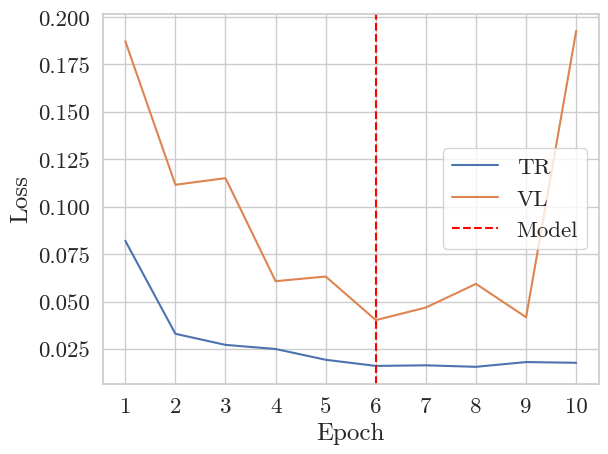

In [45]:
plt.plot(train_losses, label='TR')
plt.plot(val_losses, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=5, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
plt.legend()
plt.savefig('learning_curves_A.png',  bbox_inches="tight")
plt.show()

/tmp/ipykernel_389034/2747301518.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_accs, label='TR')


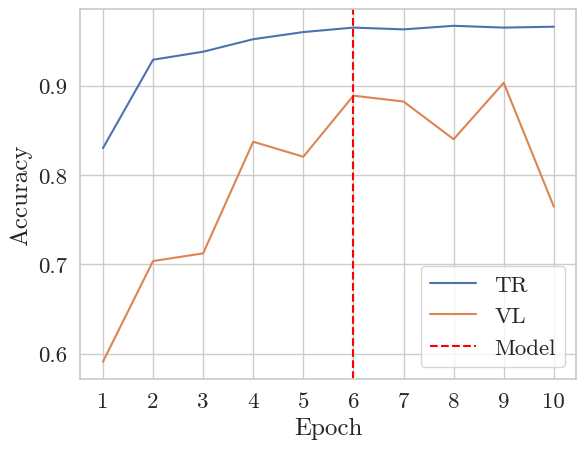

In [48]:
plt.plot(train_accs, label='TR')
plt.plot(val_accs, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=5, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
plt.legend()
plt.savefig('accs_A.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_389034/1392079603.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_f1s, label='TR')


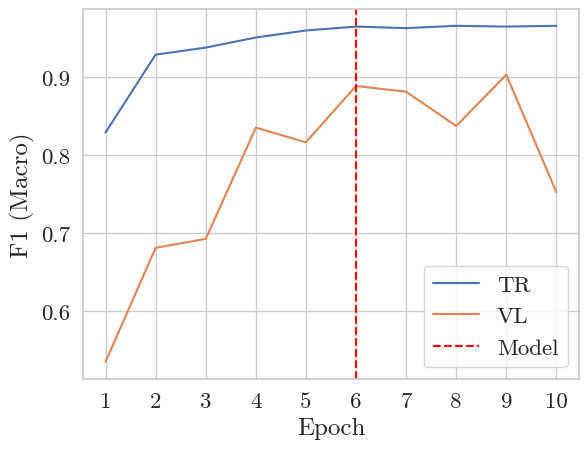

In [50]:
plt.plot(train_f1s, label='TR')
plt.plot(val_f1s, label='VL')
plt.xlabel('Epoch')
plt.ylabel('F1 (Macro)')
plt.axvline(x=5, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
plt.legend()
plt.savefig('f1s_A.png', bbox_inches="tight")
plt.show()

## Testing

In [28]:
prompt_tuning_init_text = 'Decide if the following text has been written by a human (0) or by a language model (1).'
print(len(tokenizer(prompt_tuning_init_text)['input_ids']))

24


In [29]:
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, 
    prompt_tuning_init=PromptTuningInit.TEXT, 
    num_virtual_tokens=24, 
    prompt_tuning_init_text=prompt_tuning_init_text,
    tokenizer_name_or_path=model_tokenizer_path,
)

In [30]:
trained_parameters = 'mistral_A_epoch_5.pth' # file pth with model at epoch 5
model = AutoModelForCausalLM.from_pretrained(model_tokenizer_path, torch_dtype=torch.float16)
model = get_peft_model(model, peft_config)
model.load_state_dict(torch.load(trained_parameters)) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [32]:
outputs = list()
for step, batch in enumerate(tqdm(test)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # deterministic auto-regressive generation imposing  max_new_tokens=1
            batch_out = model.generate(**batch, max_new_tokens=1, do_sample=False, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)
            decoded_batch_out = tokenizer.batch_decode(batch_out.detach().cpu().numpy(), skip_special_tokens=True)
            outputs.extend(decoded_batch_out)

  0%|          | 0/1497 [00:00<?, ?it/s]

/home/g.fidone/hlt/lib/python3.10/site-packages/peft/peft_model.py:1166: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


In [33]:
y_pred = get_labels_from_texts(outputs, [0, 1])

In [34]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.992     0.960     0.976      6298
           1      0.957     0.991     0.974      5678

    accuracy                          0.975     11976
   macro avg      0.974     0.976     0.975     11976
weighted avg      0.975     0.975     0.975     11976



/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


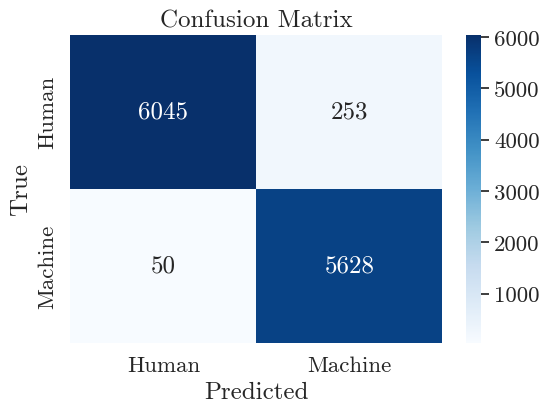

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_A.png', bbox_inches="tight")
plt.show()